# DBSCAN Outliers Removal

In [32]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from collections import defaultdict
from scipy.stats.stats import pearsonr
from copy import deepcopy
from IPython.display import display, Markdown, Latex
from sklearn.decomposition import PCA
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler
warnings.filterwarnings('ignore')

img = 'plots/figure_{}.png'
dataFolder = '../../data/{}'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
np. set_printoptions(precision=3)

def load_dataset(cols=None):

    if cols is not None:
            df = pd.read_csv(dataFolder.format('customer_behavior_normalized.csv'), usecols=cols)
    else:
        df = pd.read_csv(dataFolder.format('customer_behavior_normalized.csv'))
    df = df.set_index('CustomerID')
    return df

def load_dataset_not_normalized(cols=None):

    if cols is not None:
            df = pd.read_csv(dataFolder.format('customer_behavior.csv'), usecols=cols)
    else:
        df = pd.read_csv(dataFolder.format('customer_behavior.csv'))
    df = df.set_index('CustomerID')
    return df

def visualize_in_2d(df):
    display(Markdown('### Visualization in 2D'))
    plt.figure()
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data = principalComponents, columns= ['principal component 1', 'principal component 2'])
    plt.title("Visualization of the Customers")
    plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'], s=10)
    plt.show()
    display(Markdown('## '))


def analyze_PCA_dimensions(df, n=None):
    display(Markdown('### Analysis of the PCA'))

    if n is None:
        n = len(df.columns)-1
        
    pca = PCA(n_components=n)
    pca.fit(df)
    variance = pca.explained_variance_ratio_ 
    var=np.cumsum(np.round(variance, 3)*100)
    plt.figure()
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Features')
    plt.title('PCA Analysis')
    plt.ylim(0,100.5)
    plt.plot(var)
    plt.show()
    display(Markdown('## '))


def reduce_df_to_n_dimensions(df, n):
    reduced_df = PCA(n_components=n).fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df, columns=['pc1', 'pc2'])
    return reduced_df

def grid_search(df, order_by):
    display(Markdown('### Gridsearch results'))

    ns = []
    eps = []
    sil_wn = []
    sil = []
    nlab = []
    labels_da_riutilizzare = {}

    for s in [1, 2, 5, 10, 15, 20, 25, 30, 35, 40]:
        for e in  np.arange(0.1, 0.5, 0.1):

            dbscan = DBSCAN(eps=e, min_samples=s)
            dbscan.fit(df)

            try:
                n = len(set(dbscan.labels_))-1
                if n > 1:
                    temp_df = deepcopy(reduced_df)
                    temp_df['labels'] = dbscan.labels_
                    temp_df=temp_df[temp_df['labels']>-1]
                    labels = deepcopy(temp_df['labels'])
                    del temp_df['labels']

                    score_wn = silhouette_score(temp_df, labels)
                    score = silhouette_score(reduced_df, dbscan.labels_)

                    if score > 0 and score_wn > 0:
                        nlab.append(n)
                        ns.append(s)
                        eps.append(e)
                        sil.append(score)
                        sil_wn.append(score_wn)
            except:
                continue

    results = pd.DataFrame({'samples':ns, 
                            'eps':eps, 
                            'silhouette': sil,
                            'silhouette (w/o noise)':sil_wn, 
                            '|labels|  (w/o noise label)':nlab}
                          )
    #display(results)
    results = results.sort_values(order_by, ascending=False).reset_index()
    del results['index']
    display(results.head())
    display(Markdown('## '))
    return results

def run_experiments(df, results, row_to_take=0):

    e = results['eps'].iloc[row_to_take]
    s = results['samples'].iloc[row_to_take]
  
    display(Markdown('### Running the experimentation'))
    print(f"eps: {e}, n_samples={s}")

    dbscan = DBSCAN(eps=e, min_samples=s)
    dbscan.fit(df)
    
    df['labels'] = dbscan.labels_
    
    reduced_df = PCA(n_components=2).fit_transform(df)
    reduced_df = pd.DataFrame(reduced_df, columns=['pc1', 'pc2'])

    print("Labels found (w/o noise): ",len(set(dbscan.labels_))-1)
    reduced_df['labels'] = dbscan.labels_
    plt.figure()
    plt.scatter(reduced_df['pc1'], reduced_df['pc2'], c=dbscan.labels_, s=20, cmap='Spectral')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title("DBSCAN with noise")
    plt.savefig(img.format('DBSCAN_outlier_removal_1'))
    plt.show()
    
    reduced_df['labels'] = dbscan.labels_
    
    reduced_df_cleaned = reduced_df[reduced_df['labels']>-1]
    print(f"len(reduced_df_cleaned)={len(reduced_df_cleaned)}")
    plt.scatter(reduced_df_cleaned['pc1'], reduced_df_cleaned['pc2'], c=reduced_df_cleaned['labels'], s=20, cmap='Spectral')
    plt.tick_params(axis='both', which='major', labelsize=10)
    plt.title("DBSCAN without noise")
    plt.savefig(img.format('DBSCAN_outlier_removal_2'))
    plt.show()
    
    return df[df['labels']>-1]

# Trying on a dataset reduced to 2D

### Visualization in 2D

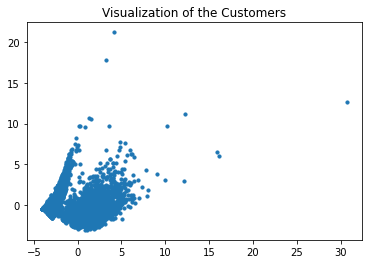

## 

### Analysis of the PCA

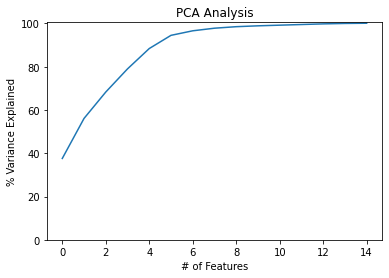

## 

### Gridsearch results

,samples,eps,silhouette,silhouette (w/o noise),|labels| (w/o noise label)
0,20,0.4,0.515750,0.577494,2
1,25,0.4,0.512633,0.592453,2
2,30,0.4,0.506622,0.602837,2
3,35,0.4,0.500061,0.612265,2
4,40,0.4,0.492226,0.621616,2


## 

In [33]:
df_not_normalized = load_dataset_not_normalized()
df = load_dataset()
visualize_in_2d(df)
analyze_PCA_dimensions(df)
reduced_df = reduce_df_to_n_dimensions(df, 2)
reduced_df.index = df.index
results = grid_search(df=reduced_df, order_by='silhouette')

### Running the experimentation

eps: 0.4, n_samples=20
Labels found (w/o noise):  2


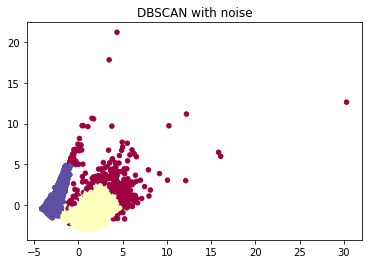

len(reduced_df_cleaned)=3724


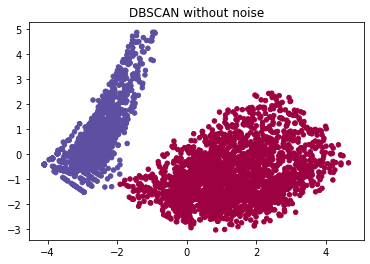

In [34]:
dataset_experiments = run_experiments(reduced_df, results)
id_to_keep = dataset_experiments[dataset_experiments['labels'] != -1 ]
cleaned = df[df.index.isin(id_to_keep.index)]
cleaned.to_csv(dataFolder.format('customer_behavior_normalized_wo_noise.csv'))

### Visualization in 2D

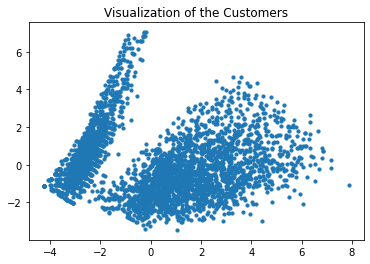

## 

In [35]:
cleaned = StandardScaler().fit_transform(cleaned)
visualize_in_2d(cleaned)

In [36]:
cleaned = df_not_normalized[df_not_normalized.index.isin(id_to_keep.index)]
cleaned.to_csv(dataFolder.format('customer_behavior_wo_noise.csv'))